Last updated 27 August 2017

In [1]:
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# $K$-means Clustering

We first start on an example 2D dataset that will help us gain an intuition of how the $K$-means algorithm works. After that, we will use the $K$-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

In [2]:
data2 = sio.loadmat("./ex7data2.mat")
Xdata2 = data2["X"]

#### Implementation notes for `find_closest_centroids()` function

`_X` is passed as a 2D $m$ by $n$ array, where $m$ is the number of data examples, and $n$ is the number of features. `_centr` is passed as a 2D $k$ by $n$ array, where $k$ is the number of centroids, and $n$ is the number of features.

Broadcasting is used extensively for high performance. The function performs the following steps:

1. It reshapes `_X` from 2D to 3D, inserting a placeholder dimension to form new array `_Xresh`. Axis 0 in `_Xresh` indexes into a specific data example, while axis 2 indexes into a specific feature of the selected data example.
2. `np.repeat()` is applied to axis 1 of `_Xresh` to duplicate the coordinates (or features) of each data example. The resulting `_stretch` array has axes 1 and 2 dimensions that match the axes 0 and 1 of `_centr` (trailing dimensions match), allowing for a broadcasted difference computation in the next step.
3. Broadcasting is now applied to find, for each data example, the difference between that respective data example's coordinates and all the coordinates of each and every centroid. The resultant `_diff` array is 2D.
4. `np.sum()` and `np.square()` are applied to `_diff` along the correct axes to give the `_eudists` array. In `_eudists`, each data example is indexed by axis 0, the euclidean distance between that data example and each centroid. For a given data example, its euclidean distance to each centroid is therefore indexed by axis 1 in `_eudists`.

The function returns the closest cluster value that each data example belongs to. In other words, it assigns each centroid to the data examples which it is nearest to.

In [3]:
def find_closest_centroids(_X, _centr):
    _Xresh = _X.reshape(_X.shape[0],1, _X.shape[1])
    _stretch = np.repeat(_Xresh, _centr.shape[0], axis=1)
    _diffs = _stretch - _centr  # Compute the difference 
    _eudists = np.sum(np.square(_diffs), axis = 2) # Compute the euclidean squared distance
    return np.argmin(_eudists,axis = 1) # return cluster value of each centroid based on min distance

In [4]:
# Passes the test case
Xtestcase = np.reshape(np.sin(np.arange(1,51)), (10,5), 'F'); centrtestcase = Xtestcase[6:10]
find_closest_centroids(Xtestcase, centrtestcase)

array([0, 1, 2, 3, 3, 0, 0, 1, 2, 3])

#### Implementation notes for `compute_centroid_means()` function

`_X` is passed as a 2D $m$ by $n$ array, where $m$ is the number of data examples, and $n$ is the number of features. `_idx` is passed as a 1D $m$ array, where $m$ is the number of data examples. `_K` is an integer specifying the number of centroids, $k$.

An array holding the new mean coordinates of each centroid is first initialized. The algorithm then iterates over each centroid, in each iteration, fancy boolean indexing is employed to obtain the data examples belonging under the given centroid's cluster. A transpose is necessary in order for `np.mean()` with `axis=1` to correctly broadcast the computation over the coordinates/features for each data example in the cluster.

In [5]:
def compute_centroid_means(_X, _idx, _K):
    _centrmeans = np.zeros((_K, _X.shape[1]))
    for k in range(0,_K):
        _centrmeans[k] = np.mean(_X[_idx == k].T, axis = 1)
    return _centrmeans

In [6]:
# Passes the test case
Xtestcase = np.reshape(np.arange(1,25),(8,3), 'F'); idxtestcase = np.array([0,0,2,2,3,3,1,1]); Ktestcase = 4
compute_centroid_means(Xtestcase, idxtestcase, Ktestcase)

array([[  1.5,   9.5,  17.5],
       [  7.5,  15.5,  23.5],
       [  3.5,  11.5,  19.5],
       [  5.5,  13.5,  21.5]])

In [7]:
def init_centroids(_X, _K):
    _idxs = np.arange(0, _X.shape[0])
    np.random.shuffle(_idxs)
    return _X[_idxs][0:_K]

In [8]:
def k_means(_X, _K, _numiter):
    _centr = init_centroids(_X,_K)
    for i in range(0, _numiter):
        _idx = find_closest_centroids(_X, _centr) 
        _centr = compute_centroid_means(_X, _idx, _K) # Update the centroid positions with the new means
    return _centr, _idx

In [9]:
K = 3; maxiter = 10
centr , idx = k_means(Xdata2,K,maxiter)

In [10]:
Xdata2clust = np.hstack([Xdata2, idx.reshape(idx.shape[0],1)]) # Append cluster information to the data matrix

clusters = []
for k in range(0,K):
    clustk = Xdata2[Xdata2clust[:,2] == k]
    clustkplot = go.Scatter(x = clustk[:,0], y= clustk[:,1], mode = "markers", name= "Cluster {}".format(k))
    clusters.append(clustkplot)

centrplot = go.Scatter(x = centr[:,0], y= centr[:,1], mode = "markers",
                       marker=dict(symbol="circle-cross", size=15, color = "black"), name= "Centroids")

plotly.offline.iplot({"data": [centrplot] + clusters,
                      "layout": go.Layout(title = "Results of clustering",
                                          xaxis = dict(title="X1"),
                                          yaxis = dict(title="X2"))})

TODO: For animating the K-means plot, refer to following articles https://plot.ly/python/animations/ https://plot.ly/python/gapminder-example/ https://plot.ly/python/sliders/. Will also need to rewrite k_means() function to return a vector after each iteration, storing into a matrix.

### Concluding remarks on clustering

In general, there is no one single best way for deciding what value of $k$ to use, the problem of [determining cluster count](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). However, a good approach is to always ask what is your purpose of running $k$-means, and to choose the value of $k$ that best reflects the goal you are trying to achieve with clustering your data.

## Image compression with $K$-means

In this exercise, we will apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. The image contains thousands of colors, and in this part of the exercise, we will reduce the number of colors to 16 colors by using just 16 clusters in $K$-means.

Compressing an image can also be interpreted [as a form of](https://www.quora.com/What-are-the-applications-of-vector-quantization) of [vector quantization](https://en.wikipedia.org/wiki/Vector_quantization). As this exercise illustrates, vector quantization is in fact a very important [application](https://en.wikipedia.org/wiki/K-means_clustering#Vector_quantization) of $k$-means. 

For further discussions on the connections between vector quantization and $k$-means, see the following articles [1](https://dsp.stackexchange.com/questions/38602/lloyd-max-quantization-and-clustering-part-1), [2](https://dsp.stackexchange.com/questions/38606/difference-between-clustering-and-quantization-part-2) and [3](https://stackoverflow.com/questions/9012991/difference-between-k-means-clustering-and-vector-quantization).

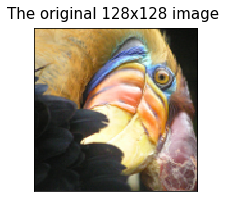

In [11]:
from scipy.misc import imread

bird = imread("bird_small.png")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (3,3))
axes.imshow(bird)
axes.set(xticks=[], yticks=[])
fig.suptitle("The original 128x128 image", fontsize = 15)
fig

In [12]:
birdresh = bird.reshape(bird.shape[0]*bird.shape[1], bird.shape[2])  # reshape image to support K-means

In [13]:
K = 16; maxiter = 500
colors , idx = k_means(birdresh,K,maxiter) # Run k-means to cluster the pixels

In [14]:
# Reconstructing the compressed image
idxim = idx.reshape(bird.shape[0],bird.shape[1])
birdnew = np.zeros_like(bird)
# Assign the chosen color using the clustered centroid
for i in range(0,bird.shape[0]):
    for j in range(0,bird.shape[1]):
        birdnew[i][j] = colors[idxim[i][j]]

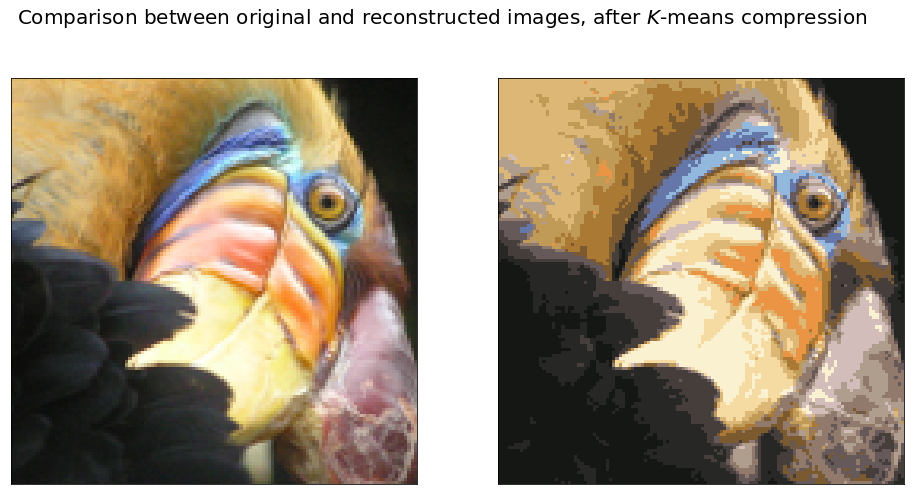

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,8))
axes[0].imshow(bird)
axes[0].set(xticks=[], yticks=[])
axes[1].imshow(birdnew)
axes[1].set(xticks=[], yticks=[])
fig.suptitle("Comparison between original and reconstructed images, after $K$-means compression", fontsize = 20)
fig

By decreasing $K$, we can get a higher compression rate at the expense of image quality, and increasing $K$ we can get a better image quality at the expense of a lower compression rate.

# Principal Component Analysis



In [16]:
data1 = sio.loadmat("ex7data1.mat")
Xdata1 = data1["X"]
data1plot = go.Scatter(x = Xdata1[:,0], y= Xdata1[:,1],mode = "markers", name = "Dataset 1")
plotly.offline.iplot({"data": [data1plot],
                      "layout": go.Layout(title = "Example Dataset 1")})

In [17]:
# Implementation of normalization follows exercise 5
def feature_normalize(_X):
    _mu = np.mean(_X, axis=0)
    _Xnorm = _X-_mu
    _sigma = np.std(_Xnorm, axis=0, ddof=1)
    _Xnorm = _Xnorm / _sigma
    return _Xnorm, _mu, _sigma

TODO: Figure out why the assignment gives covariance formula as $\Sigma = \frac{1}{m} X^T X$ and not $\Sigma = \frac{1}{m} X X^T$. Shouldn't the latter be the correct one since covariance matrix, by definition, has to be m by m (m = number of data examples)? Using the former only gives us n by n (n=number of features).

In [18]:
def compute_covariance_matrix(_X):
    return 1/_X.shape[0] * (_X @ _X.T)

In [19]:
from numpy.linalg import svd

def compute_pca(_Xnorm):
    _Xcovar = compute_covariance_matrix(_Xnorm)    
    _U, _S, _V = svd(_Xcovar)
    return _U, _S

In [20]:
Xdata1norm, mu, sigma = feature_normalize(Xdata1)
U,S = compute_pca(Xdata1norm)

TODO: Figure out why Eigenvector 1 is not showing up well
TODO: Understand how the eig0 and eig1 syntax works (it was copied over from the course provided code)

In [21]:
eig0 = mu + 1.5 * S[0] * U[:,0].reshape(50,1)
eig1 = mu + 1.5 * S[1] * U[:,1].reshape(50,1)

eig0plot = go.Scatter(x = eig0[:,0], y= eig0[:,1],mode = "line", name="Eigenvector 0")
eig1plot = go.Scatter(x = eig1[:,0], y= eig1[:,1],mode = "line", name= "Eigenvector 1")
plotly.offline.iplot({"data": [data1plot,eig0plot, eig1plot],
#plotly.offline.iplot({"data": [data1plot,eig0plot],
                      "layout": go.Layout(title = "Example Dataset 1")})

# Further Readings

PCA rings bells of linear regression in my head, the two felt very similar. There's also a method combining the two, which the following links clarify https://shankarmsy.github.io/posts/pca-vs-lr.html https://www.quora.com/Is-principal-components-regression-the-same-as-doing-PCA-and-then-linear-regression https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues http://www.cerebralmastication.com/2010/09/principal-component-analysis-pca-vs-ordinary-least-squares-ols-a-visual-explination/ https://stackoverflow.com/questions/8457279/visual-comparison-of-regression-pca

Stanford CS168 course notes lecture 7 foudn on http://web.stanford.edu/class/cs168/ also explain the connections between linear regression and PCA.

Help on interpreting PCA: http://setosa.io/ev/principal-component-analysis/ being derived from SVD http://www.ams.org/samplings/feature-column/fcarc-svd 

Useful article for PCA https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues and https://deeplearning4j.org/eigenvector#principal



This chapter talks about cluster analysis in food science and technology applications, makes for interesting read showing how market segmentation in food science can be achieved http://onlinelibrary.wiley.com/doi/10.1002/9781118434635.ch7/summary

This is a really end of exercise note, but just to mention that within these class of algos, also good to learn about t-SNE https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
